<div style="text-align: center"><font size="3">
 <b>Genre Classification Based on Album Art Using Convolutional Neural Networks</b>
<br> Cassidy Newberry & Mateen Saifyan
</font>
</div>

In [128]:
import numpy as np
import pandas as pd
import torch
import os
import shutil

from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
import cv2

import torchvision

import albumentations as A

from tqdm.notebook import tqdm
from torchvision import models, transforms
import matplotlib.pyplot as plt

## Data

### **Pre-Processing**

First we need to create a dataframe that correctly maps images and their file paths to the appropriate genre label. We will do this by joining the amazon_id from the MuMu single genre label dataset with the Amazon metadata dataset, which includes the url for album covers. We will then take all unique album covers and create a dataframe consisting of the unique album covers of the top 12 genres in the dataset.

In [63]:
df = pd.read_csv('MuMu_dataset/MuMu_dataset_single-label.csv')

In [64]:
df.head(2)

,amazon_id,album_mbid,MSD_track_id,recording_mbid,artist_mbid,genres
0,B0018ZB6ZO,0164b5ce-42f8-46bf-b140-61ecd2ed449e,TRYDUXK12903CE0C37,66dd470f-4c4f-4caa-b8d4-2ebc80a83cb6,7434b85a-4a06-42ba-9e1d-9c568c044842,Dance & Electronic
1,B0018ZB6ZO,0164b5ce-42f8-46bf-b140-61ecd2ed449e,TRGWXYX128F426E27F,b45aef36-c3a3-42f2-90fb-728e8b3c54a2,7434b85a-4a06-42ba-9e1d-9c568c044842,Dance & Electronic


In [65]:
len(df)

12087

In [67]:
df['album_mbid'].nunique()

2321

In [68]:
df['genres'].nunique()

16

In [89]:
# DATA CLEANING
df_reduced = df.drop_duplicates(['amazon_id', 'album_mbid']) #only one instance of album art
top_genres = list(df_reduced['genres'].value_counts()[-4:].index)  #top 12 genres
df_top_genres = df_reduced[~df_reduced['genres'].isin(top_genres)].reset_index(drop=True)
df_top_genres['genres'].value_counts()

Dance & Electronic    518
Rock                  391
Jazz                  266
Alternative Rock      260
Country               151
Pop                   139
R&B                   127
Metal                 119
Rap & Hip-Hop         103
Latin Music            95
Blues                  66
Folk                   32
Name: genres, dtype: int64

In [90]:
len(df_top_genres)

2267

In [92]:
df_top_genres.head(3)

,amazon_id,album_mbid,MSD_track_id,recording_mbid,artist_mbid,genres
0,B0018ZB6ZO,0164b5ce-42f8-46bf-b140-61ecd2ed449e,TRYDUXK12903CE0C37,66dd470f-4c4f-4caa-b8d4-2ebc80a83cb6,7434b85a-4a06-42ba-9e1d-9c568c044842,Dance & Electronic
1,B000003HGR,7fe6e337-9115-3719-855b-0441c42a2c36,TRVMIIJ12903CDBF1D,36b15f42-b441-4d64-8ba9-ca264ed1c6f1,1b54e90c-638e-4fdd-a20e-4ab09db9fdaf,Alternative Rock
2,B0000564CN,d825b1ab-e260-3eb7-b486-5cb58ba0391f,TRPDZTD12903CBFC4B,aaf7c510-dc3d-4d39-81b0-81acf226fa09,570938b4-8fe5-44f9-ab43-9438feb03c6f,R&B


In [74]:
df_img = pd.read_json('MuMu_dataset/amazon_metadata_MuMu.json')
df_img.tail(3)

,title,price,imUrl,amazon_id,related,categories,salesRank,brand
31468,NaN,34.45,http://ecx.images-amazon.com/images/I/51UgnZe%...,B00KE5M5IQ,"{'also_bought': [], 'bought_together': ['B00K6...","[[CDs & Vinyl, Latin Music, Latin Pop]]",{'Music': 7262},NaN
31469,NaN,15.39,http://ecx.images-amazon.com/images/I/51obnT4n...,B00KG10ZXU,"{'also_bought': [], 'also_viewed': ['B00000265...","[[CDs & Vinyl, Broadway & Vocalists], [CDs & V...",{'Music': 15508},NaN
31470,NaN,NaN,http://ecx.images-amazon.com/images/I/51cOvY8o...,B00KOEQSTY,"{'also_bought': [], 'buy_after_viewing': []}","[[CDs & Vinyl, Pop], [CDs & Vinyl, Rock]]",{'Music': 101106},NaN


In [93]:
#join the dataframes
df_combined = df_top_genres.set_index('amazon_id').join(df_img.set_index('amazon_id'), on='amazon_id', how='inner')

### **Download Data**

Now the tricky part, we have to actually download the data using the URLs given by the DataFrame in order to build a proper dataset for our convolutional neural networks. We will iterate through each row and download the album art locally. We will then build a dataframe to track where this file is downloaded and the genre label associated with that file path so that we can iterate through each file individually in our dataset. 

In [137]:
def download_dataset(df, dir_name='train'):
    file_df = pd.DataFrame(columns=['filepath', 'genre', 'data set'])
    if os.path.exists(dir_name):
        shutil.rmtree(dir_name)
    os.mkdir(dir_name)
    for genre in df['genres'].unique():
        if os.path.exists(dir_name+'/'+genre):
                shutil.rmtree(dir_name+'/'+genre)
        os.mkdir(dir_name+'/'+genre)
        for index, row in tqdm(df[df['genres'] == genre].iterrows()):
            f_name = dir_name+'/'+genre+'/'+index+'.png'
            file_df = file_df.append({'filepath': f_name, 'genre': row['genres'], 'data set': dir_name}, ignore_index=True)
            response = requests.get(row['imUrl'])
            f = open(f_name, 'wb')
            f.write(response.content)
            f.close()
    return file_df

In [138]:
df_train, df_valid = train_test_split(df_combined, test_size=0.2)

In [139]:
df_train = download_dataset(df_train, 'train')

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [175]:
def build_dataframe(dir_name):
    df_copy = pd.DataFrame(columns=['filepath', 'genre', 'data set'])
    for genre in os.listdir(dir_name):
        for file in os.listdir(dir_name+'/'+genre):
            df_copy = df_copy.append({'filepath': dir_name+'/'+genre+'/'+file, 'genre': genre, 'data set': dir_name}, ignore_index=True)
    return df_copy

In [264]:
def clean_data(df):
    drop_index = []
    for i, file in enumerate(df.filepath):
        if cv2.imread(file) is None:
            drop_index.append(i)
    df = df.drop(df.index[drop_index]).reset_index(drop=True)
    return df

In [265]:
df_train = build_dataframe('train')
df_train

,filepath,genre,data set
0,train/Pop/B000008JZ9.png,Pop,train
1,train/Pop/B0013YTSFU.png,Pop,train
2,train/Pop/B001SJ6U1K.png,Pop,train
3,train/Pop/B00022UBNC.png,Pop,train
4,train/Pop/B007XNAQQ0.png,Pop,train
...,...,...,...
1809,train/Jazz/B000JBWUH6.png,Jazz,train
1810,train/Jazz/B000U0MJAO.png,Jazz,train
1811,train/Jazz/B008HLI4KW.png,Jazz,train
1812,train/Jazz/B000000GLF.png,Jazz,train


In [266]:
df_train = clean_data(df_train)
df_train

,filepath,genre,data set
0,train/Pop/B000008JZ9.png,Pop,train
1,train/Pop/B0013YTSFU.png,Pop,train
2,train/Pop/B001SJ6U1K.png,Pop,train
3,train/Pop/B00022UBNC.png,Pop,train
4,train/Pop/B007XNAQQ0.png,Pop,train
...,...,...,...
1750,train/Jazz/B000JBWUH6.png,Jazz,train
1751,train/Jazz/B000U0MJAO.png,Jazz,train
1752,train/Jazz/B008HLI4KW.png,Jazz,train
1753,train/Jazz/B000000GLF.png,Jazz,train


In [164]:
df_valid = download_dataset(df_valid, 'valid')

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [177]:
df_valid = build_dataframe('valid')
df_valid

,filepath,genre,data set
0,valid/Pop/B000003PE2.png,Pop,valid
1,valid/Pop/B00144V7US.png,Pop,valid
2,valid/Pop/B00002JX9S.png,Pop,valid
3,valid/Pop/B0014JNT8G.png,Pop,valid
4,valid/Pop/B00004YRG0.png,Pop,valid
...,...,...,...
449,valid/Jazz/B009SFNHTE.png,Jazz,valid
450,valid/Jazz/B005NNJL3Q.png,Jazz,valid
451,valid/Jazz/B000LKARI4.png,Jazz,valid
452,valid/Jazz/B000KWAETU.png,Jazz,valid


In [267]:
df_valid = clean_data(df_valid)
df_valid

,filepath,genre,data set
0,valid/Pop/B00144V7US.png,Pop,valid
1,valid/Pop/B00002JX9S.png,Pop,valid
2,valid/Pop/B0014JNT8G.png,Pop,valid
3,valid/Pop/B00004YRG0.png,Pop,valid
4,valid/Pop/B00004Y1NN.png,Pop,valid
...,...,...,...
430,valid/Jazz/B009SFNHTE.png,Jazz,valid
431,valid/Jazz/B005NNJL3Q.png,Jazz,valid
432,valid/Jazz/B000LKARI4.png,Jazz,valid
433,valid/Jazz/B000KWAETU.png,Jazz,valid


### **Datasets**

In [268]:
class GenresDataset(Dataset):
    def __init__(self, df):
        self.df = df
        #labels dictionary
        self.label_dict = {genre: i for i, genre in enumerate(df.genre.unique())}
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        path = row['filepath']
        img = cv2.imread(path)
        img = cv2.resize(img, (256,256))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = np.transpose(img, (2, 0, 1))
        img = torch.tensor(img / 255.).float()
        genre = torch.tensor(self.label_dict[row['genre']])
            
        return img, genre

In [269]:
ds_train = GenresDataset(df_train)
ds_val = GenresDataset(df_valid)
dl_train = DataLoader(ds_train, batch_size = 8, shuffle = True)
dl_val = DataLoader(ds_val, batch_size = 8, shuffle = True)

In [302]:
next(iter(ds_train))

(tensor([[[0.4941, 0.5020, 0.5216,  ..., 0.0824, 0.0863, 0.0863],
          [0.4353, 0.4431, 0.4627,  ..., 0.0706, 0.0745, 0.0745],
          [0.3647, 0.3725, 0.3843,  ..., 0.0588, 0.0588, 0.0588],
          ...,
          [0.1608, 0.2235, 0.3294,  ..., 0.1451, 0.1373, 0.1333],
          [0.1922, 0.2471, 0.3451,  ..., 0.1412, 0.1608, 0.1725],
          [0.2118, 0.2667, 0.3569,  ..., 0.1412, 0.1804, 0.2000]],
 
         [[0.5373, 0.5451, 0.5647,  ..., 0.1412, 0.1451, 0.1451],
          [0.4784, 0.4902, 0.5020,  ..., 0.1294, 0.1294, 0.1333],
          [0.4078, 0.4157, 0.4275,  ..., 0.1098, 0.1137, 0.1176],
          ...,
          [0.1451, 0.2078, 0.3216,  ..., 0.2392, 0.2314, 0.2275],
          [0.1725, 0.2314, 0.3373,  ..., 0.2353, 0.2549, 0.2667],
          [0.1922, 0.2510, 0.3490,  ..., 0.2353, 0.2745, 0.2941]],
 
         [[0.5451, 0.5569, 0.5725,  ..., 0.1608, 0.1647, 0.1647],
          [0.4863, 0.4941, 0.5137,  ..., 0.1490, 0.1490, 0.1529],
          [0.4118, 0.4235, 0.4353,  ...,

## Models

### **Baseline - Convolutional Neural Network**

In [272]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        
        self.linear1 = nn.Linear(16384, 100)
        self.linear2 = nn.Linear(100, 12) #12 different genres
    
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)    
        self.relu = nn.ReLU()
        self.unroll = nn.Flatten()
        
    def forward(self, x):
        
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)
        
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x)
        
        x = self.conv3(x)
        x = self.relu(x)
        x = self.pool(x)
        
        x = self.conv4(x)
        x = self.relu(x)
        x = self.pool(x)
        
        x = self.conv5(x)
        x = self.relu(x)

        x = self.linear1(self.unroll(x))
        x = self.relu(x)
        x = self.linear2(x)
        
        return x
    
model = CNN()

In [273]:
from torchsummary import summary
summary(model, input_size = (3, 256, 256), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 256, 256]             896
              ReLU-2         [-1, 32, 256, 256]               0
         MaxPool2d-3         [-1, 32, 128, 128]               0
            Conv2d-4         [-1, 64, 128, 128]          18,496
              ReLU-5         [-1, 64, 128, 128]               0
         MaxPool2d-6           [-1, 64, 64, 64]               0
            Conv2d-7          [-1, 128, 64, 64]          73,856
              ReLU-8          [-1, 128, 64, 64]               0
         MaxPool2d-9          [-1, 128, 32, 32]               0
           Conv2d-10           [-1, 64, 32, 32]          73,792
             ReLU-11           [-1, 64, 32, 32]               0
        MaxPool2d-12           [-1, 64, 16, 16]               0
           Conv2d-13           [-1, 64, 16, 16]          36,928
             ReLU-14           [-1, 64,

In [274]:
def one_pass(model, dataloader, optimizer, lossFun, backwards=True, print_loss=False):
    
    if backwards == True:
        model.train()
    else:
        model.eval()
    
    total_loss = 0.0
    for x, y in tqdm(dataloader):
        
        y_pred = model(x)
        loss = lossFun(y_pred, y)
        total_loss += loss.item()
        
        if backwards == True:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    avg_loss = total_loss / len(dataloader)
    
    if print_loss == True:
        print(avg_loss)
    
    return avg_loss

def one_pass_acc(model, dataloader, num_points):
    model.eval()
    total_incorrect = 0
    
    softmax = nn.LogSoftmax(dim=1)
    
    for x, y in dataloader:
        y_pred = softmax(model(x))
        y_pred = torch.argmax(y_pred, dim=1)
        
        total_incorrect += torch.count_nonzero(y - y_pred).item()
        
    percent_wrong = total_incorrect / num_points
    return 1 - percent_wrong

In [275]:
def train_model(model, ds_train, dl_train, ds_val, dl_val, num_epochs=5):
    optimizer = optim.Adam(model.parameters(), lr = 0.01)
    lossFun = nn.CrossEntropyLoss()

    train_losses = []
    valid_losses = []

    for epoch in tqdm(range(num_epochs)):
        print('Epoch: ', epoch)

        train_loss = one_pass(model, dl_train, optimizer, lossFun)
        train_losses.append(train_loss)
        print('Train loss: ', train_loss)

        valid_loss = one_pass(model, dl_val, optimizer, lossFun, backwards=False)
        valid_losses.append(valid_loss)
        print('Valid loss: ', valid_loss)

        train_acc = one_pass_acc(model, dl_train, len(ds_train))
        valid_acc = one_pass_acc(model, dl_val, len(ds_val))
        print('Train Acc: ', train_acc)
        print('Valid Acc: ', valid_acc)

In [276]:
train_model(model, ds_train, dl_train, ds_val, dl_val)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  0


  0%|          | 0/220 [00:00<?, ?it/s]

Train loss:  2.623141374913129


  0%|          | 0/55 [00:00<?, ?it/s]

Valid loss:  2.3062387531453914
Train Acc:  0.23589743589743595
Valid Acc:  0.21149425287356327
Epoch:  1


  0%|          | 0/220 [00:00<?, ?it/s]

Train loss:  2.2445982813835146


  0%|          | 0/55 [00:00<?, ?it/s]

Valid loss:  2.305061440034346
Train Acc:  0.23589743589743595
Valid Acc:  0.21149425287356327
Epoch:  2


  0%|          | 0/220 [00:00<?, ?it/s]

Train loss:  2.238109961423007


  0%|          | 0/55 [00:00<?, ?it/s]

Valid loss:  2.3175086064772175
Train Acc:  0.23589743589743595
Valid Acc:  0.21149425287356327
Epoch:  3


  0%|          | 0/220 [00:00<?, ?it/s]

Train loss:  2.2380557119846345


  0%|          | 0/55 [00:00<?, ?it/s]

Valid loss:  2.314336960965937
Train Acc:  0.23589743589743595
Valid Acc:  0.21149425287356327
Epoch:  4


  0%|          | 0/220 [00:00<?, ?it/s]

Train loss:  2.239817634495822


  0%|          | 0/55 [00:00<?, ?it/s]

Valid loss:  2.3056785908612336
Train Acc:  0.23589743589743595
Valid Acc:  0.21149425287356327


In [277]:
torch.save(model, 'base_cnn')

### **Transfer Learning - VGG16 CNN**

Our lack of data meant that training a convolution neural network from scratch could lead to results less accurate than those we could achieve using transfer learning. By taking a pre-trained VGG16 model we could use pre-trained weights with a developed understanding of features and tune these to match our task, hopefully increasing the effectiveness in predicting a single genre for albums based on their cover art. We used a partially frozen VGG-16 with the last 

In [278]:
vgg16 = models.vgg16(pretrained=True)

In [279]:
summary(vgg16, input_size = (3, 256, 256), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           1,792
              ReLU-2         [-1, 64, 256, 256]               0
            Conv2d-3         [-1, 64, 256, 256]          36,928
              ReLU-4         [-1, 64, 256, 256]               0
         MaxPool2d-5         [-1, 64, 128, 128]               0
            Conv2d-6        [-1, 128, 128, 128]          73,856
              ReLU-7        [-1, 128, 128, 128]               0
            Conv2d-8        [-1, 128, 128, 128]         147,584
              ReLU-9        [-1, 128, 128, 128]               0
        MaxPool2d-10          [-1, 128, 64, 64]               0
           Conv2d-11          [-1, 256, 64, 64]         295,168
             ReLU-12          [-1, 256, 64, 64]               0
           Conv2d-13          [-1, 256, 64, 64]         590,080
             ReLU-14          [-1, 256,

In [280]:
for param in vgg16.parameters():
            param.requires_grad = False

In [281]:
vgg16.classifier._modules['6'] = nn.Linear(4096, 12)
print(vgg16.classifier._modules['6'])

Linear(in_features=4096, out_features=12, bias=True)


In [282]:
params_to_update = []

for param in vgg16.parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
print(params_to_update)

optimizer = optim.Adam(params_to_update, lr=0.001)

[Parameter containing:
tensor([[ 0.0109,  0.0082,  0.0094,  ..., -0.0124, -0.0033, -0.0017],
        [ 0.0036,  0.0020, -0.0099,  ..., -0.0028,  0.0152,  0.0034],
        [-0.0139,  0.0057, -0.0156,  ...,  0.0034, -0.0091,  0.0128],
        ...,
        [ 0.0005,  0.0115, -0.0110,  ..., -0.0034,  0.0081, -0.0064],
        [ 0.0038, -0.0139, -0.0050,  ...,  0.0106,  0.0111, -0.0147],
        [-0.0008, -0.0116,  0.0038,  ...,  0.0145, -0.0030,  0.0137]],
       requires_grad=True), Parameter containing:
tensor([-0.0039,  0.0018,  0.0153, -0.0125,  0.0114,  0.0047, -0.0143, -0.0125,
         0.0060, -0.0100,  0.0022, -0.0125], requires_grad=True)]


In [286]:
train_model(vgg16, ds_train, dl_train, ds_val, dl_val, num_epochs=2)

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch:  0


  0%|          | 0/220 [00:00<?, ?it/s]

Train loss:  8.076274379275063


  0%|          | 0/55 [00:00<?, ?it/s]

Valid loss:  7.724146912314675
Train Acc:  0.5094017094017094
Valid Acc:  0.2183908045977011
Epoch:  1


  0%|          | 0/220 [00:00<?, ?it/s]

Train loss:  8.122371929883958


  0%|          | 0/55 [00:00<?, ?it/s]

Valid loss:  10.126967516812412
Train Acc:  0.4757834757834758
Valid Acc:  0.23678160919540225


In [284]:
torch.save(vgg16, 'vgg16')

### **Applying Our Model**

In [359]:
pred_dict = GenresDataset(df_train).label_dict

def get_genre(val):
    for key, value in pred_dict.items():
        if val == value:
            return key
    return None

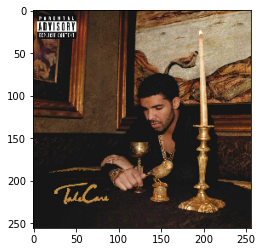

In [431]:
img = cv2.imread('data/takecare.jpg')
img = cv2.resize(img, (256,256))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
img = np.transpose(img, (2, 0, 1))
img = np.reshape(img, [1, 3, img.shape[1], img.shape[2]])
img = torch.tensor(img / 255.).float()

In [432]:
model.eval()
softmax = nn.LogSoftmax(dim=1)

y_pred = softmax(model(img))
y_pred = torch.argmax(y_pred, dim=1)
get_genre(y_pred.item())

'Dance & Electronic'

In [433]:
vgg16.eval()
softmax = nn.LogSoftmax(dim=1)

y_pred = softmax(vgg16(img))
y_pred = torch.argmax(y_pred, dim=1)
get_genre(y_pred.item())

'Country'

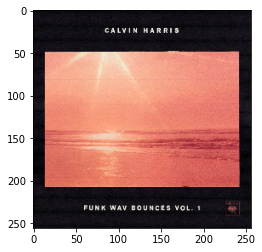

In [434]:
img = cv2.imread('data/calvinharris.webp')
img = cv2.resize(img, (256,256))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
img = np.transpose(img, (2, 0, 1))
img = np.reshape(img, [1, 3, img.shape[1], img.shape[2]])
img = torch.tensor(img / 255.).float()

In [435]:
model.eval()
softmax = nn.LogSoftmax(dim=1)

y_pred = softmax(model(img))
y_pred = torch.argmax(y_pred, dim=1)
get_genre(y_pred.item())

'Dance & Electronic'

In [436]:
vgg16.eval()
softmax = nn.LogSoftmax(dim=1)

y_pred = softmax(vgg16(img))
y_pred = torch.argmax(y_pred, dim=1)
get_genre(y_pred.item())

'Dance & Electronic'